[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Segment Anything Model (SAM)

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/segment-anything) [![arXiv](https://img.shields.io/badge/arXiv-2304.02643-b31b1b.svg)](https://arxiv.org/abs/2304.02643)

Segment Anything Model (SAM): a new AI model from Meta AI that can "cut out" any object, in any image, with a single click. SAM is a promptable segmentation system with zero-shot generalization to unfamiliar objects and images, without the need for additional training. This notebook is an extension of the [official notebook](https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb) prepared by Meta AI.

![segment anything model](https://media.roboflow.com/notebooks/examples/segment-anything-model-paper.png)

## Complementary Materials

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb) [![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/D-D6ZmadzPE) [![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/how-to-use-segment-anything-model-sam)

We recommend that you follow along in this notebook while reading the blog post on Segment Anything Model.

![segment anything model blogpost](https://media.roboflow.com/notebooks/examples/segment-anything-model-blogpost.png)

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- **Before you start** - Make sure you have access to the GPU
- Install Segment Anything Model (SAM)
- Download Example Data
- Load Model
- Automated Mask Generation
- Generate Segmentation with Bounding Box
- Segment Anything in Roboflow Universe Dataset

## Let's begin!

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

## Install Segment Anything Model (SAM) and other dependencies

In [ ]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

In [ ]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

### Download SAM weights

In [ ]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [1]:
import os
# CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
CHECKPOINT_PATH = '/mobileye/RPT/users/kfirs/kfir_project/MSC_Project/SAM_checkpoints/sam_vit_h_4b8939.pth' #os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
# CHECKPOINT_PATH_WINDOWS = r'\\dfs.me-corp.lan\mobileye\RPT\users\kfirs\kfir_project\MSC_Project\SAM_checkpoints\sam_vit_h_4b8939.pth'
# print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

## Load Model

In [2]:
import torch
import tkinter as tk
from tkinter import filedialog
from IPython.display import display
import ipywidgets as widgets
import open3d as o3d
from open3d.cuda.pybind.geometry import TriangleMesh
import numpy as np
import cv2


# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')
MODEL_TYPE = "vit_h"


# Function to open file dialog and get the file path
def select_file():
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askopenfilename(filetypes=[("OBJ files", "*.obj")])
    path_widget.value = file_path

# Create a button widget
button_widget = widgets.Button(description="Select .obj file")

# Create a text widget to display the file path
path_widget = widgets.Text(
    value='',
    placeholder='File path will appear here',
    description='File Path:',
    disabled=False
)


def load_mesh(filename):
    """ Load a mesh from an OBJ file and return its vertices and normals. """
    mesh: TriangleMesh = o3d.io.read_triangle_mesh(filename)
    if not mesh.has_vertex_normals():
        mesh.compute_vertex_normals()
    vertices = np.asarray(mesh.vertices)
    normals = np.asarray(mesh.vertex_normals)  # Assume normals are already normalized
    return vertices, normals

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [4]:
mask_predictor = SamPredictor(sam)

# Define function to create ortho image

In [5]:
# Bind the function to the button click event
button_widget.on_click(lambda b: select_file())

# Display the widgets
display(button_widget)
display(path_widget)


Button(description='Select .obj file', style=ButtonStyle())

Text(value='', description='File Path:', placeholder='File path will appear here')

In [6]:
from orthograohic_image import capture_textured_image_from_obj
image_path, rotation_matrix,camera_intrinsics = capture_textured_image_from_obj(path_widget.value)
print(image_path)

[Open3D WARNING] [ViewControl] ConvertFromPinholeCameraParameters() failed because window height and width do not match.
./images/S01_ortho.png


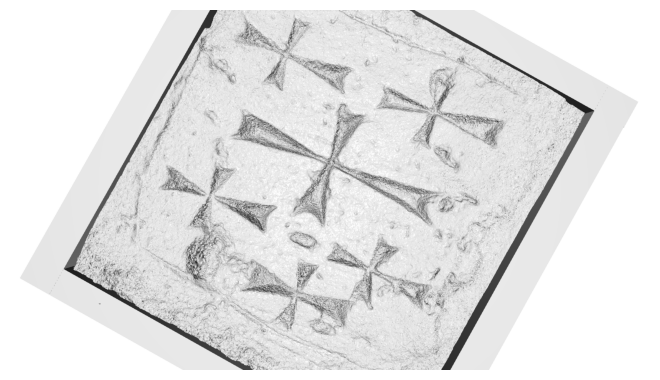

In [7]:
import matplotlib.pyplot as plt

# Load the orthoimage
ortho_image = cv2.imread(image_path)

# Display the orthoimage
plt.imshow(ortho_image, cmap='gray')
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.show()

### Draw Box



In [8]:
from numpy import ndarray
from typing import Union
# helper function that loads an image before adding it to the widget

import base64

def encode_image(input: Union[str,ndarray]):
    if isinstance(input, str):     
        with open(input, "rb") as image:
            image_bytes = image.read()
    else:
        image_bytes = cv2.imencode('.jpg', input)[1]
        
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [9]:
IS_COLAB = False

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget( classes=['cross'])
widget.image = encode_image(image_path)

# Set resolution of the image
widget.width = ortho_image.shape[1]
widget.height = ortho_image.shape[0]


widget

BBoxWidget(classes=['cross'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377…

In [10]:
widget.bboxes

[{'x': 453, 'y': 454, 'width': 352, 'height': 219, 'label': 'cross'},
 {'x': 684, 'y': 11, 'width': 362, 'height': 249, 'label': 'cross'},
 {'x': 1107, 'y': 157, 'width': 381, 'height': 263, 'label': 'cross'},
 {'x': 697, 'y': 743, 'width': 334, 'height': 223, 'label': 'cross'},
 {'x': 947, 'y': 672, 'width': 320, 'height': 225, 'label': 'cross'},
 {'x': 659, 'y': 276, 'width': 629, 'height': 375, 'label': 'cross'}]

### Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [11]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

boxes = []
for box in widget.bboxes:
    boxes.append(np.array([
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ]))
    
if not boxes:
    boxes = [default_box]

In [12]:
import cv2
import numpy as np
import supervision as sv

# Use the orthoimage as the input image
image_bgr = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_GRAY2RGB)

# Set the image for the mask predictor
mask_predictor.set_image(image_rgb)

# Initialize lists to store masks, scores, and logits for each box
all_masks = []
all_scores = []
all_logits = []
best_masks = []
best_scores = []

# Predict masks for each box
for box in boxes:
    masks, scores, logits = mask_predictor.predict(
        box=box,
        multimask_output=True
    )
    all_masks.append(masks)
    all_scores.append(scores)
    all_logits.append(logits)
    
    mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
    
    # Select the mask with the highest score
    best_index = np.argmax(scores)
    best_masks.append(masks[best_index])
    best_scores.append(scores[best_index])
    
    # Run another round of prediction with the best masks as mask_input to refine the masks
    best_m, best_s, _ = mask_predictor.predict(
        box=box,
        mask_input=mask_input[None, :, :],
        multimask_output=False,
    )

    best_masks[-1] = best_m[0]
    best_scores[-1] = best_s[0]
    

# Convert lists to numpy arrays
best_masks = np.array(best_masks)
best_scores = np.array(best_scores)

### Results visualisation with Supervision

SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


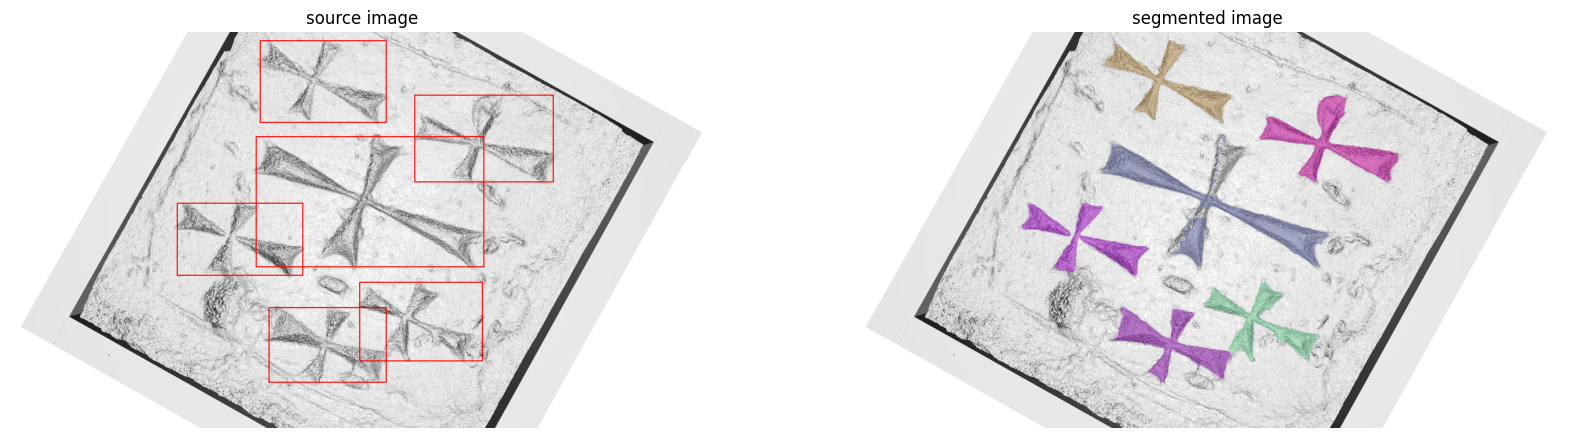

In [13]:

# Create a color lookup table with unique colors for each mask
num_masks = best_masks.shape[0]
mask_colors  = np.random.randint(0, 255, (num_masks, 3))

# Create detections object with the best masks
detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=best_masks),
    mask=best_masks
)

# Annotate the image with boxes
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
source_image = box_annotator.annotate(scene=image_rgb.copy(), detections=detections, skip_label=True)

# Annotate the image with masks using unique colors
segmented_image = image_rgb.copy()
for i, mask in enumerate(detections.mask):
    color = sv.Color(*mask_colors [i])
    mask_annotator = sv.MaskAnnotator(color=color)
    mask_detections = sv.Detections(xyxy=np.array([detections.xyxy[i]]), mask=np.array([mask]))
    segmented_image = mask_annotator.annotate(scene=segmented_image, detections=mask_detections, custom_color_lookup=lambda x: color)

# Display the images in a grid and increase the size of the grid
sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    size=(20, 10),
    titles=['source image', 'segmented image']
)

### Masks and their scores visualisation

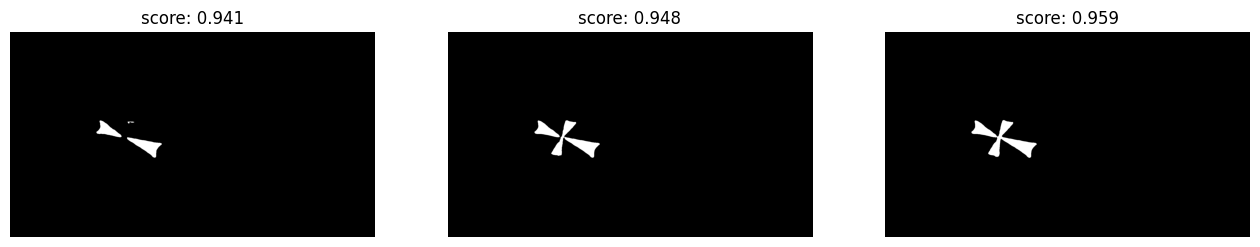

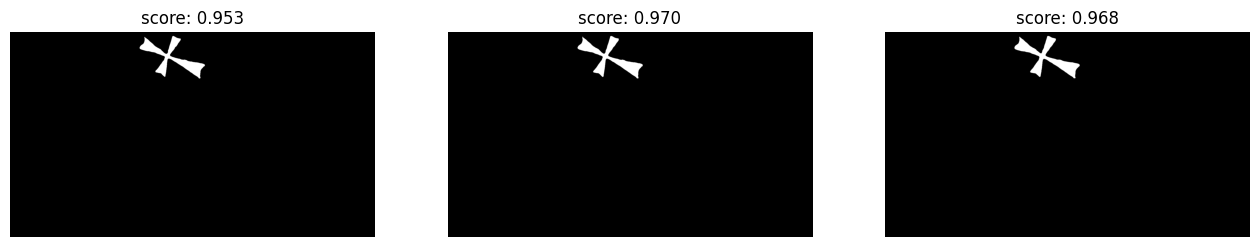

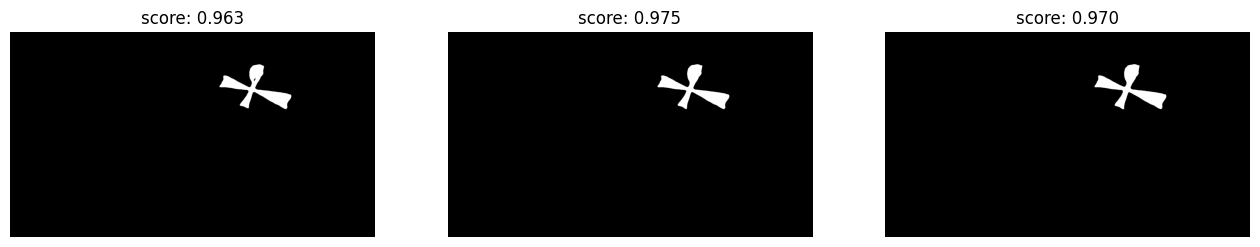

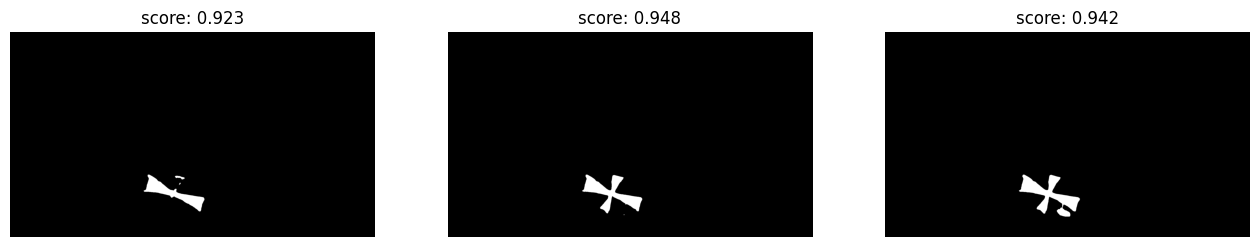

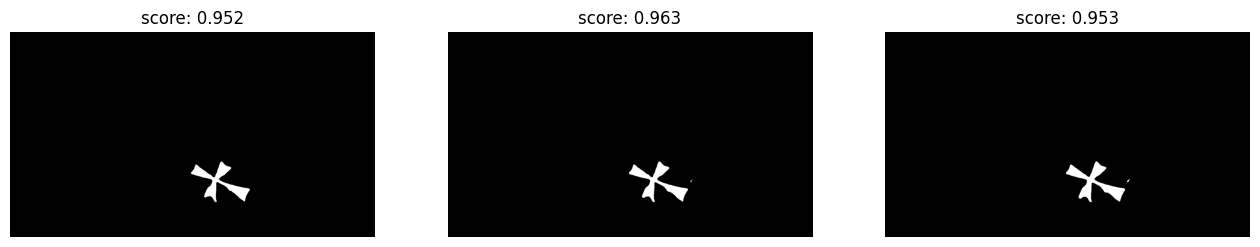

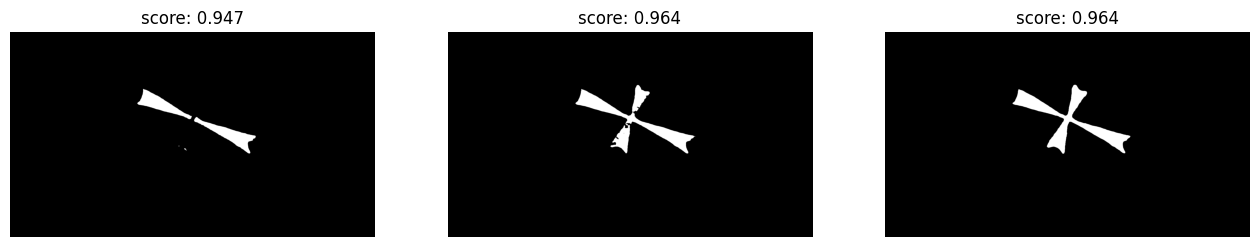

In [14]:
# Visualize all masks with their scores for each box
for i, (masks, scores) in enumerate(zip(all_masks, all_scores)):
    sv.plot_images_grid(
        images=masks,
        grid_size=(1, len(masks)),
        size=(16, 4),
        titles=[f"score: {score:.3f}" for score in scores]
    )

In [ ]:
from project_masks_to_3d import project_masks_to_point_cloud
# Project masks back to 3D and color them
pcd = project_masks_to_point_cloud(obj_path=path_widget.value,json_path=camera_intrinsics, masks=best_masks, mask_colors=mask_colors)

In [ ]:
# Create and visualize the colored point cloud
point_cloud = o3d.geometry.PointCloud(pcd)
o3d.visualization.draw_geometries([point_cloud])